In [1]:
!pip install tensorflow
!pip install tensorflow keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
keras = tf.keras

E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [3]:
#defining window
def window_dataset(series, window_size, batch_size=10,
                   shuffle_buffer=10):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
#forcasting
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(16).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
# reading the dataset
df = pd.read_csv(r"C:\Users\sakif\Desktop\Forecasting using ML\Project\Main Folder\csiro_alt_gmsl_mo_2015_csv_edited.csv")
df['id'] = df.index
time = df.index
series = df.GMSL

In [6]:
#prepeaaring dataset
split_time = 180
time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]

window_size = 5
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_test, window_size)

In [7]:
#defining model
model = keras.models.Sequential()
model.add(keras.layers.Dense(80, activation="relu", input_shape=[window_size]))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(25, activation="relu"))
model.add(keras.layers.Dense(1))

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
trained = model.fit(train_set, epochs=50)

dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
18/18 [==============================] - 0s 11ms/step - loss: 18.7904 - mean_absolute_error: 19.1128
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 10.2754 - mean_absolute_error: 10.7525
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 2.7604 - mean_absolute_error: 3.2621
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 2.4043 - mean_absolute_error: 2.8937
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 2.5299 - mean_absolute_error: 3.0245
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 2.4497 - mean_absolute_error: 2.9688
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 2.5958 - mean_absolute_error: 3.0934
Epoch 8/50
18/18 [==

<IPython.core.display.Javascript object>


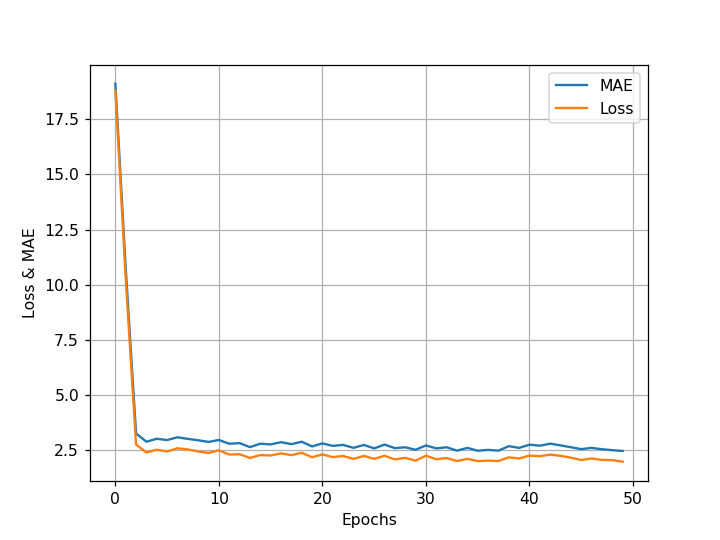

In [10]:
%matplotlib notebook
#plotting MAE and loss
plt.plot(trained.history['mean_absolute_error'], label="MAE")
plt.plot(trained.history['loss'], label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss & MAE")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#plotting values
%matplotlib notebook
fig, axs = plt.subplots(2)
plt.grid(True)

axs[0].bar(time, series, alpha=1)
axs[0].set(ylabel='Sea Level Rise (mm)', xlabel='1993-2014', title="Original Data")

axs[1].plot(time_train, x_train, label='Training Data')
axs[1].plot(time_test, x_test, label='Test Data')
axs[1].plot(time_test, dense_forecast, label='Predicted Data')
axs[1].legend(loc='upper left', frameon=True)
axs[1].set(ylabel='Sea Level Rise (mm)', xlabel='1993-2014', title="Forecasting")

plt.show()

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1)
plt.grid(True)
axs.plot(time_train, x_train, label='Training Data')
axs.plot(time_test, x_test, label='Test Data')
axs.plot(time_test, dense_forecast, label='Predicted Data')
axs.legend(loc='upper left', frameon=True)
axs.set(ylabel='Sea Level Rise (mm)', xlabel='1993-December to 2015-January', title="Forecasting")

plt.show()

In [ ]:
#test set MAE
errors = dense_forecast - x_test
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print("Test set Mean Absolute Error ", mae)